# 1. Librerías y Configuraciones Iniciales

In [2]:
# General
import os
from typing import Tuple
import random
from collections import Counter
from PIL import Image
import time

# Pytorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets, transforms
import torchvision.models as models
import torch.optim as optim
from torch.quantization import QuantStub, DeQuantStub, get_default_qconfig, fuse_modules
from torchviz import make_dot
os.environ["PATH"] += r";C:\Program Files\Graphviz\bin"

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger

# Hydra
import hydra
from hydra.core.global_hydra import GlobalHydra
from omegaconf import DictConfig
from omegaconf import OmegaConf

# W&B
import wandb

# Sklearn
from sklearn.model_selection import train_test_split

# Matplotlib
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter

## 1.1. Comprobacion de pytorch y CUDA

In [215]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Device Name:", torch.cuda.get_device_name(0))

PyTorch version: 2.5.1+cu118
CUDA available: True
CUDA version: 11.8
Device Name: NVIDIA GeForce RTX 3060 Ti


## 1.2. Configuración de librerías

In [216]:
random.seed(42)

# Configuración de Weights & Biases
wandb.login()

True

## 1.3. Globales y constantes

In [4]:
#------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Para la ejecución y corrida con los experimentos y configuraciones de hiperparámetros se utiliza Hydra, un framework open-source
# que simplifica el desarrollo de experimentos basado en una configuración jerárquica.
#------------------------------------------------------------------------------------------------------------------------------------------------------------------
GlobalHydra.instance().clear()
hydra.initialize(config_path=".", version_base=None)
cfg = hydra.compose(config_name="config")

print(OmegaConf.to_yaml(cfg))

CHECKPOINTS_PATH = 'checkpoints'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_WORKERS = 4

model:
  learning_rate: 0.003
  batch_size: 16
  epochs: 10
  patience: 3
  train_dataset_dir: data/train
  validation_dataset_dir: data/valid
  test_dataset_dir: data/test
data:
  labeled_percentage: 0.3



# 2. Definiciones generales

## 2.1. Denoising Autoencoder

In [218]:
class DenoisingAutoencoder(pl.LightningModule):
    def __init__(self, input_channels=3, output_channels=3, learning_rate=1e-3):
        super(DenoisingAutoencoder, self).__init__()
        self.learning_rate = learning_rate

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Encoder
        self.enc1 = self.conv_block(input_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.dec4 = self.upconv_block(1024, 512)
        self.dec3 = self.upconv_block(512 + 512, 256)
        self.dec2 = self.upconv_block(256 + 256, 128)
        self.dec1 = self.upconv_block(128 + 128, 64)

        # Final layer
        self.final_layer = nn.Conv2d(128, output_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential \
        (
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )


    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential \
        (
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
    
    
    def forward(self, x):
        # Encoder
        # print("\nx:", x.shape)  # Muestra las dimensiones de la entrada
        enc1 = self.enc1(x)
        # print("enc1 size:", enc1.shape)  # Muestra las dimensiones después de la primera capa

        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        # print("enc2 size:", enc2.shape)  # Muestra las dimensiones después de la segunda capa

        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        # print("enc3 size:", enc3.shape)  # Muestra las dimensiones después de la tercera capa

        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        # print("enc4 size:", enc4.shape)  # Muestra las dimensiones después de la cuarta capa

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        # print("bottleneck size:", bottleneck.shape)  # Muestra las dimensiones del cuello de botella


        # Decoder
        dec4 = self.dec4(bottleneck)
        # print("dec4 size:", dec4.shape)  # Muestra las dimensiones después de la primera capa del decodificador
        dec4 = torch.cat((dec4, enc4), dim=1)
        # print("dec4 after concatenation size:", dec4.shape)  # Después de concatenar

        dec3 = self.dec3(dec4)
        # print("dec3 size:", dec3.shape)  # Muestra las dimensiones después de la segunda capa del decodificador
        dec3 = torch.cat((dec3, enc3), dim=1)
        # print("dec3 after concatenation size:", dec3.shape)  # Después de concatenar

        dec2 = self.dec2(dec3)
        # print("dec2 size:", dec2.shape)  # Muestra las dimensiones después de la tercera capa del decodificador
        dec2 = torch.cat((dec2, enc2), dim=1)
        # print("dec2 after concatenation size:", dec2.shape)  # Después de concatenar

        dec1 = self.dec1(dec2)
        # print("dec1 size:", dec1.shape)  # Muestra las dimensiones después de la cuarta capa del decodificador
        dec1 = torch.cat((dec1, enc1), dim=1)
        # print("dec1 after concatenation size:", dec1.shape)  # Después de concatenar
        
        # Output layer
        output = self.final_layer(dec1)
        # print("Output size:", output.shape)  # Muestra las dimensiones de la salida
        return output
    


    #------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Debe redefinir como mínimo los métodos de training_step, test_step, configure_optimizers
    #------------------------------------------------------------------------------------------------------------------------------------------------------------------
    def training_step(self, batch, batch_idx):
        inputs, _ = batch  # Ignora las etiquetas
        outputs = self(inputs)
        loss = F.mse_loss(outputs, inputs)
        self.log('train_loss', loss)
        return loss

    
    def test_step(self, batch, batch_idx):
        inputs, _ = batch  # Ignora las etiquetas
        outputs = self(inputs)
        loss = F.mse_loss(outputs, inputs)
        self.log('test_loss', loss)
        return loss
    

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

## 2.2. Salt and Pepper

La función add_salt_and_pepper_noise aplica ruido "sal y pimienta" a imágenes en formato de tensor, introduciendo píxeles aleatorios blancos (sal) y negros (pimienta). La cantidad de píxeles afectados se determina por el parámetro amount, mientras que la proporción entre sal y pimienta se ajusta con salt_vs_pepper. Se generan coordenadas aleatorias para los píxeles afectados y se modifica la imagen clonada, estableciendo los píxeles de sal en 1 y los de pimienta en 0. Esto simula ruido común en imágenes digitales, útil para robustecer modelos ante datos contaminados.

In [219]:
def add_salt_and_pepper_noise(images, salt_vs_pepper=0.5, amount=0.02):
    noisy = images.clone()
    num_salt = int(amount * images.numel() * salt_vs_pepper)
    num_pepper = int(amount * images.numel() * (1.0 - salt_vs_pepper))

    salt_coords = [
        np.random.randint(0, i - 1, num_salt) for i in images.shape
    ]
    pepper_coords = [
        np.random.randint(0, i - 1, num_pepper) for i in images.shape
    ]

    noisy[tuple(salt_coords)] = 1
    noisy[tuple(pepper_coords)] = 0
    return noisy

La clase mostrada en la siguiente entrada, extiende de torch.utils.data.Dataset para generar un dataset que combina imágenes originales y versiones con ruido. Al obtener un ítem del dataset, la clase aplica el ruido a la imagen original, asegurando que las transformaciones y clonaciones sean independientes. Esto permite usar imágenes limpias y ruidosas en paralelo para entrenar el modelo, integrándolo fácilmente con los DataLoader.

In [220]:
class NoisyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if isinstance(img, torch.Tensor):
            img = img.detach().clone()  # Asegura que sea un tensor independiente
        elif self.transform:
            img = self.transform(img)  # Transforma solo si no es tensor
        noisy_img = add_salt_and_pepper_noise(img)
        return noisy_img, img


## 2.3. Clase de Carga

In [221]:
class CustomLoader(pl.LightningDataModule):
    def __init__(self, dataset: Dataset, batch_size=32):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size


    def split(self, labeled_percentage) -> Tuple[Dataset, Dataset]:
        labels = [sample[1] for sample in self.dataset.samples]        
        
        # División estratificada
        labeled_indices, unlabeled_indices = train_test_split \
        (
            range(len(self.dataset)),
            test_size=1 - labeled_percentage,
            stratify=labels
        )

        labeled_subset = Subset(self.dataset, labeled_indices)
        unlabeled_subset = Subset(self.dataset, unlabeled_indices)
        
        labeled_dataset = self.create_dataset_from_subset(labeled_subset)
        unlabeled_dataset = self.create_dataset_from_subset(unlabeled_subset)

        return labeled_dataset, unlabeled_dataset


    def create_dataset_from_subset(self, subset):
        samples = [self.dataset.samples[idx] for idx in subset.indices]
        new_dataset = datasets.ImageFolder(root=self.dataset.root, transform=self.dataset.transform)
        new_dataset.samples = samples
        new_dataset.targets = [sample[1] for sample in samples]  # Actualizar etiquetas
        return new_dataset


    def get_dataloader(self):
        return DataLoader(self.labeled_data, batch_size=self.batch_size, shuffle=True)

# 3. Procesamiento y manejo de datos e imágenes

## 3.1. Transformaciones

In [222]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


## 3.2. Crear los datasets a partir de las muestras preprocesadas

In [223]:
class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

## 3.3. Carga de las muestras

In [224]:
# El dataset no redimensiona las imágenes de forma inmediata al ser cargadas en memoria. Las imágenes se cargan solo cuando accedes a ellas.
# Las transformaciones se aplican cada vez que accedes a una imagen, no al momento de la creación del dataset. Esto significa que la imagen será
# redimensionada solo cuando el dataset realmente cargue la imagen durante el entrenamiento o la evaluación (cuando haces una iteración sobre el dataset).

train_full_dataset = datasets.ImageFolder(root=cfg.model.train_dataset_dir)
test_full_dataset = datasets.ImageFolder(root=cfg.model.test_dataset_dir)

train_species_counts = Counter([sample[1] for sample in train_full_dataset.samples])
top_20_species = [species for species, count in train_species_counts.most_common(20)]

train_samples_from_top_20_species_by_image_count = [sample for sample in train_full_dataset.samples if sample[1] in top_20_species]
test_samples_from_top_20_species_by_image_count = [sample for sample in test_full_dataset.samples if sample[1] in top_20_species]

train_samples = []
test_samples = test_samples_from_top_20_species_by_image_count

for specie in top_20_species:
    species_samples = [sample for sample in train_samples_from_top_20_species_by_image_count if sample[1] == specie] # if sample tag = tag
    random.shuffle(species_samples)
    train_samples.extend(species_samples[:-20])
    test_samples.extend(species_samples[-20:])


def remap_indices(samples):
    unique_indices = sorted({label for _, label in samples})
    index_map = {original: remapped for remapped, original in enumerate(unique_indices)}    
    remapped_samples = [(path, index_map[label]) for path, label in samples]
    return remapped_samples


train_samples = remap_indices(train_samples)
test_samples = remap_indices(test_samples)

print(f'Training samples: {len(train_samples)}')
print(f'Testing samples: {len(test_samples)}')


#print(train_samples)
#print(test_samples)

Training samples: 2546
Testing samples: 500


### 3.3.1. Ejemplos del dataset raw

Ejemplos del conjunto de entrenamiento:


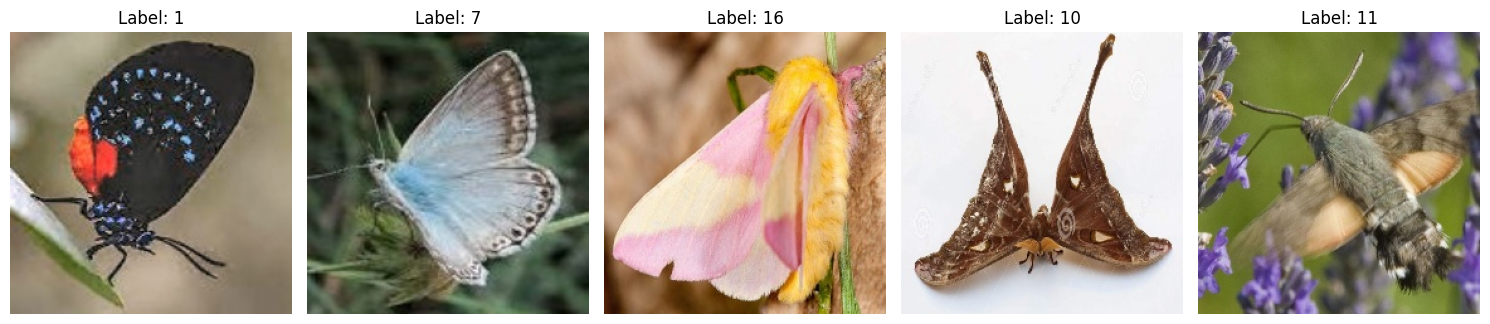

Ejemplos del conjunto de prueba:


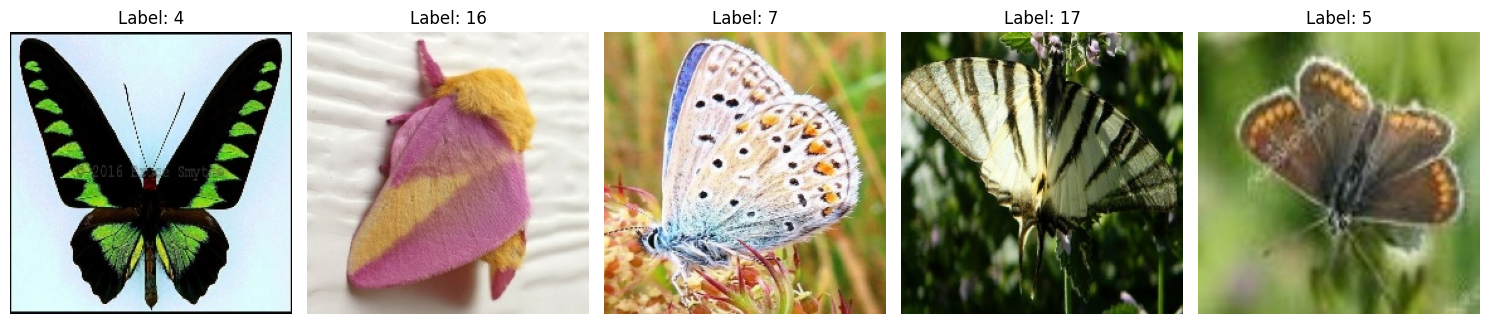

In [225]:
def show_images(samples, num_images=5):
    random_samples = random.sample(samples, num_images)
    
    # Crear subplots
    plt.figure(figsize=(15, 5))
    for i, (path, label) in enumerate(random_samples):
        img = Image.open(path)  # Cargar la imagen desde la ruta
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("Ejemplos del conjunto de entrenamiento:")
show_images(train_samples)

print("Ejemplos del conjunto de prueba:")
show_images(test_samples)


## 3.4. Creación de los dataset

In [228]:
#train_dataset = CustomDataset(train_samples, transform=transform)
#test_dataset = CustomDataset(test_samples, transform=transform)

#train_loader = DataLoader(train_dataset, batch_size=cfg.model.batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=cfg.model.batch_size, shuffle=False)

train_dataset = datasets.ImageFolder(root=cfg.model.train_dataset_dir, transform=transform)
train_dataset.samples = train_samples

test_dataset = datasets.ImageFolder(root=cfg.model.test_dataset_dir, transform=transform)
test_dataset.samples = test_samples

In [229]:
custom_loader = CustomLoader(dataset=train_dataset, batch_size=cfg.model.batch_size)
set_de_datos_con_labels, set_de_datos_sin_labels = custom_loader.split(labeled_percentage=cfg.data.labeled_percentage)

print(f"Labeled: {len(set_de_datos_con_labels.samples)}")
print(f"Unlabeled: {len(set_de_datos_sin_labels.samples)}")

# Dataloaders
train_labeled_dl = DataLoader(dataset=set_de_datos_con_labels, batch_size=cfg.model.batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
train_unlabeled_dl = DataLoader(dataset=set_de_datos_sin_labels, batch_size=cfg.model.batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

Labeled: 763
Unlabeled: 1783


## 3.5. Noisy dataset

In [230]:
train_noisy_dataset = NoisyDataset(train_dataset, transform=transform)

train_noisy_loader = DataLoader(
    train_noisy_dataset, 
    batch_size=cfg.model.batch_size, 
    shuffle=True
)

In [231]:
noisy_img, clean_img = next(iter(train_noisy_loader))
print(f"Noisy image shape: {noisy_img.shape}, Clean image shape: {clean_img.shape}")

Noisy image shape: torch.Size([16, 3, 128, 128]), Clean image shape: torch.Size([16, 3, 128, 128])


### 3.5.1. Ejemplos del dataset con salt-pepper

Ejemplos de imágenes con y sin ruido:


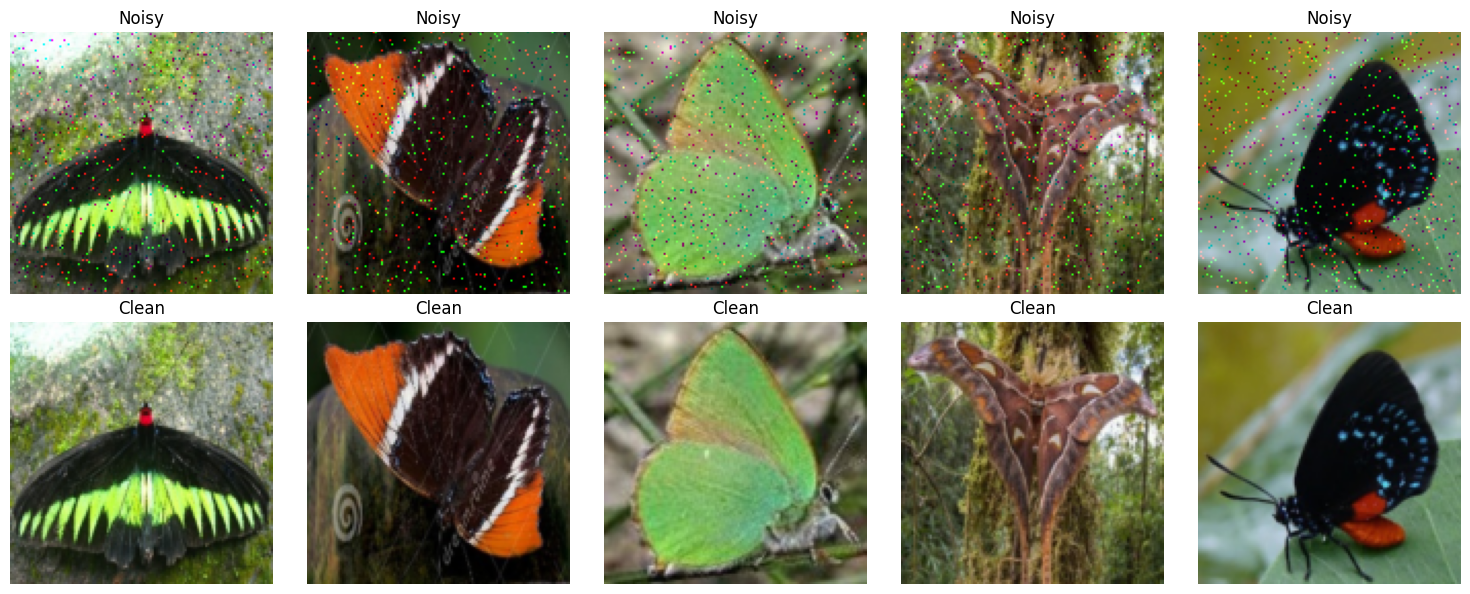

In [232]:
def show_noisy_images(loader, num_images=5):
    # Obtener un lote de datos
    noisy_imgs, clean_imgs = next(iter(loader))
    
    # Asegurarse de que no mostramos más imágenes de las disponibles
    num_images = min(num_images, noisy_imgs.shape[0])
    
    # Crear subplots
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        # Imagen con ruido
        plt.subplot(2, num_images, i + 1)
        plt.imshow(noisy_imgs[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')
        plt.title("Noisy")
        plt.axis("off")
        
        # Imagen original
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(clean_imgs[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')
        plt.title("Clean")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

print("Ejemplos de imágenes con y sin ruido:")
show_noisy_images(train_noisy_loader)

# 4. Entrenamiento

In [233]:
autoencoder = DenoisingAutoencoder().to(DEVICE)

In [234]:
def wandb_train(model: DenoisingAutoencoder, train_data_loader: DataLoader, model_name: str, wandb_project_name: str):
    wandb_logger = WandbLogger \
    (
        project=wandb_project_name,
        name=model_name,
        log_model=True  # Guarda el modelo en Wandb.
    )
    
    trainer = pl.Trainer(
        max_epochs=10,
        accelerator="gpu",  # Especifica que se usará GPU
        devices="auto",  # Usa todas las GPUs disponibles
        precision=16,  # Habilita entrenamiento en precisión mixta (16 bits)
        logger=wandb_logger,
        callbacks=[EarlyStopping(monitor="train_loss", patience=3, mode="min")]
    )

    try:
        trainer.fit(model, train_data_loader)
        filepath = os.path.join(CHECKPOINTS_PATH, f'{model_name}.ckpt')
        trainer.save_checkpoint(filepath)
    finally:
        wandb.finish()

In [235]:
wandb_train(model=autoencoder, train_data_loader=train_noisy_loader, model_name="model_exp_2", wandb_project_name="Experimento_2")

C:\Users\PC MASTER\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name        | Type       | Params | Mode 
----------------------------------------------------
0  | encoder     | Sequential | 75.6 K | train
1  | enc1        | Sequential | 38.7 K | train
2  | enc2        | Sequential | 221 K  | train
3  | enc3        | Sequential | 885 K  | train
4  | enc4        | Sequential | 3.5 M  | train
5  | bottleneck  | Sequential | 14.2 M | train
6  | dec4        | Sequential | 2.1 M  | train
7  | dec3        | Sequential | 1.0 M  | train
8  | dec2        | Sequential | 262 K  | train
9  | dec1        | Sequential | 65.6 K | train
10 | final_layer | Conv2d     | 387    | train
----------------------------------------------------
22.4 M    Trainable params
0         Non-trainable params
22.4 M    Total params
89.574    Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode
C:\Users\PC MASTER\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning

Epoch 9: 100%|███████████████████████████████████████████████████████████| 160/160 [00:10<00:00, 15.79it/s, v_num=e5kk]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████| 160/160 [00:11<00:00, 14.33it/s, v_num=e5kk]


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
epoch,9
train_loss,0.00017
trainer/global_step,1599


# 5. Modelación de clases

## 5.1. Espacio Latente

El código representado en la sección 5.1. extrae las características latentes del espacio comprimido generado por el autoencoder para luego visualizarlas utilizando t-SNE. Primero, la función extract_latent_features pasa las imágenes por el codificador del autoencoder y guarda las representaciones latentes junto con sus etiquetas. Estas características latentes son una representación de menor dimensionalidad que debería capturar las estructuras significativas de los datos originales.

Luego, se aplica t-SNE para reducir aún más las dimensiones a dos, facilitando la visualización en un gráfico de dispersión. Esto permite analizar si el espacio latente ha aprendido a modelar las clases, agrupando puntos de la misma etiqueta de forma coherente. La visualización ayuda a evaluar la capacidad del autoencoder para capturar patrones útiles en los datos, reflejando la estructura inherente de las clases.

In [236]:
def extract_latent_features(loader, model, device):
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            latent_vectors = model.encoder(images)
            features.append(latent_vectors.cpu().numpy())
            labels.extend(lbls.numpy())
    return np.concatenate(features), np.array(labels)

In [237]:
# Extraer características latentes
model = autoencoder
model.to(DEVICE)
latent_features, latent_labels = extract_latent_features(train_loader, autoencoder, DEVICE)

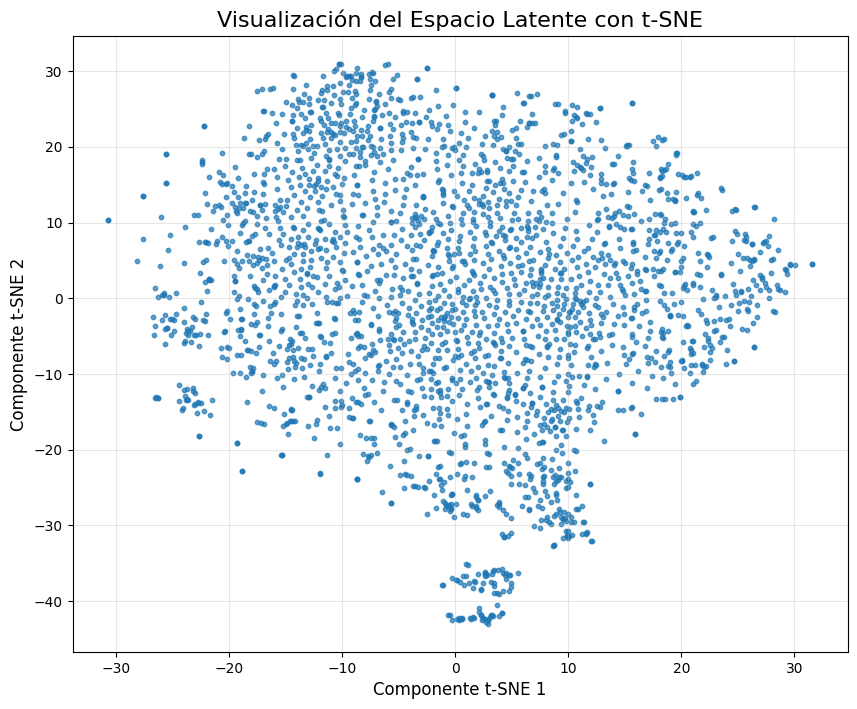

In [243]:
labels = None  

plt.figure(figsize=(10, 8))
if labels is not None:
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', s=10)
    plt.colorbar(scatter, label="Clases o Clusters") 
else:
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], s=10, alpha=0.7)

plt.title("Visualización del Espacio Latente con t-SNE", fontsize=16)
plt.xlabel("Componente t-SNE 1", fontsize=12)
plt.ylabel("Componente t-SNE 2", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [239]:
# Reducir dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(latent_features)

## 5.2. KMeans

En esta segunda parte, se aplica t-SNE para reducir las dimensiones de las características latentes a un espacio bidimensional, facilitando la visualización. Luego, se utiliza el algoritmo de clustering no supervisado K-Means para agrupar los puntos en función de su proximidad en el espacio reducido. El número de clusters se define como el número de clases presentes en las etiquetas originales.

Esta visualización permite evaluar si el modelo autoencoder logró capturar estructuras significativas en los datos. Idealmente, los puntos de cada clase deberían agruparse en clusters definidos, reflejando que el espacio latente separa correctamente las clases. Este análisis combina aprendizaje no supervisado (K-Means) con reducción de dimensionalidad (t-SNE) para validar la capacidad del espacio latente de modelar las clases originales.

In [240]:
# Clustering con K-Means
n_clusters = len(set(latent_labels))  # Número de clusters = número de clases
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_features)

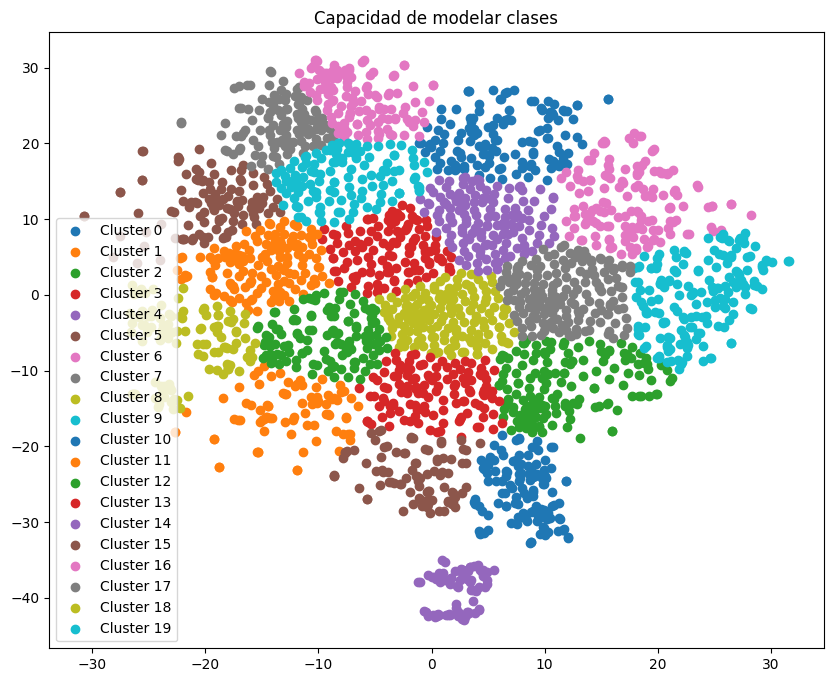

In [242]:
# Visualización de los resultados
plt.figure(figsize=(10, 8))
for cluster_idx in range(n_clusters):
    cluster_points = reduced_features[clusters == cluster_idx]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_idx}')
plt.legend()
plt.title("Capacidad de modelar clases")
plt.show()

# 6. Análisis de Resultados

## Primera Visualización (t-SNE sin etiquetas):
En la imagen mostrada en la sección 5.1., se observa la distribución de los puntos en un espacio bidimensional generado mediante t-SNE. Sin utilizar etiquetas de clase, los datos muestran una estructura dispersa, pero con ciertos patrones que sugieren la posibilidad de agrupamientos naturales en algunas regiones. Aunque no están explícitamente etiquetados, esto indica que el espacio latente ha capturado características relevantes de los datos, permitiendo una separación parcial.

## Segunda Visualización (Clustering con K-Means):
En la segunda imagen, se aplica K-Means a las características latentes reducidas, asignando etiquetas a cada muestra de manera no supervisada. Los clusters identificados se representan con diferentes colores. El resultado muestra que los puntos de cada cluster están razonablemente agrupados en el espacio bidimensional, lo que sugiere que el autoencoder ha aprendido un espacio latente capaz de reflejar similitudes intrínsecas en los datos. Sin embargo, algunos clusters pueden superponerse, lo que podría indicar que ciertas clases no están claramente separadas, probablemente debido a similitudes en sus características.

En términos generales, se puede observar que el autoencoder logra capturar información útil en el espacio latente, suficiente para que t-SNE y K-Means identificaran agrupaciones significativas.